In [1]:
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

In [3]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

1.3.0


In [4]:
# Read input_data (not as one_hot)
from tensorflow.examples.tutorials.mnist import input_data

# new folder
mnist = input_data.read_data_sets("/tmp/data/")

# Assign them to values
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [5]:
import tensorflow.examples.tutorials.mnist.mnist as mnist_info

In [6]:
mnist_info.IMAGE_PIXELS

784

In [7]:
mnist.train.images.shape

(55000, 784)

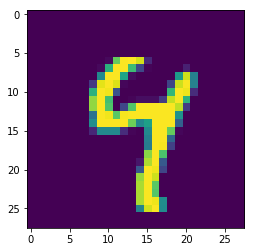

In [8]:
plt.imshow(mnist.train.images[2,:].reshape(28,28))

In [9]:
tf.reset_default_graph()

In [10]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Then every time you have specified a graph run:
# file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [11]:
# TensorBoard Graph visualizer in notebook
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Construction Phase

In [12]:
# Define hyperparameters and input size

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = 10

In [13]:
# Reset graph
tf.reset_default_graph()

In [14]:
# Placeholders for data (inputs and targets)
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [15]:
# Define neuron layers (ReLU in hidden layers)
# We'll take care of Softmax for output with loss function

def neuron_layer(X, n_neurons, name, activation=None):
    # X input to neuron
    # number of neurons for the layer
    # name of layer
    # pass in eventual activation function
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        
        # initialize weights to prevent vanishing / exploding gradients
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # Initialize weights for the layer
        W = tf.Variable(init, name="weights")
        # biases
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # Output from every neuron
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [16]:
# Define the hidden layers
with tf.name_scope("dnn"):
    keep_prob = 0.9
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    drop_out1 = tf.nn.dropout(hidden1, keep_prob)
    hidden2 = neuron_layer(drop_out1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    drop_out2 = tf.nn.dropout(hidden2, keep_prob)
    hidden3 = neuron_layer(drop_out2, n_hidden3, name="hidden3",
                           activation=tf.nn.relu)
    drop_out3 = tf.nn.dropout(hidden3, keep_prob)
    logits = neuron_layer(drop_out3, n_outputs, name="outputs")

In [17]:
# Define loss function (that also optimizes Softmax for output):

with tf.name_scope("loss"):
    # logits are from the last output of the dnn
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [18]:
# Training step with Gradient Descent

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [19]:
# Evaluation to see accuracy

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [25]:
show_graph(tf.get_default_graph())

# Evaluation phase

In [21]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 10
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt") # save model

0 Train accuracy: 0.9 Val accuracy: 0.8916
1 Train accuracy: 0.88 Val accuracy: 0.9182
2 Train accuracy: 0.98 Val accuracy: 0.9278
3 Train accuracy: 0.96 Val accuracy: 0.9376
4 Train accuracy: 0.96 Val accuracy: 0.9476
5 Train accuracy: 0.94 Val accuracy: 0.9448
6 Train accuracy: 1.0 Val accuracy: 0.9506
7 Train accuracy: 0.98 Val accuracy: 0.9538
8 Train accuracy: 0.96 Val accuracy: 0.9578
9 Train accuracy: 0.96 Val accuracy: 0.9614


# Evaluate Accuracy

In [22]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = mnist.test.images[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)

print("Predicted classes:", y_pred)
print("Actual classes:   ", mnist.test.labels[:20])

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Predicted classes: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


In [23]:
show_graph(tf.get_default_graph())